In [1]:
# https://www.sc-best-practices.org/conditions/gsea_pathway.html#id380
# Kang HM, Subramaniam M, Targ S, et al. Multiplexed droplet single-cell RNA-sequencing using natural genetic variation
#   Nat Biotechnol. 2020 Nov;38(11):1356]. Nat Biotechnol. 2018;36(1):89-94. doi:10.1038/nbt.4042

In [ ]:
model_kind = "kegg"
debug = False

In [2]:
%load_ext autoreload
%autoreload 2

import scanpy as sc
import tensorflow as tf
from tensorflow.keras.models import Model
from ivae_scorer.datasets import load_kang
from tensorflow.keras import callbacks
import shutil
from ivae_scorer.utils import set_all_seeds
from ivae_scorer.bio import get_adj_matrices, sync_gexp_adj, build_hipathia_renamers
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import minmax_scale
import matplotlib.pyplot as plt
import seaborn as sns
import dotenv
from pathlib import Path
import pandas as pd
import numpy as np
from scipy.stats import weightedtau
import keras.metrics
import joblib


project_path = Path(dotenv.find_dotenv()).parent
results_path = project_path.joinpath("results")
results_path.mkdir(exist_ok=True, parents=True)
data_path = project_path.joinpath("data")
data_path.mkdir(exist_ok=True, parents=True)
figs_path = results_path.joinpath("figs")
figs_path.mkdir(exist_ok=True, parents=True)
tables_path = results_path.joinpath("tables")
tables_path.mkdir(exist_ok=True, parents=True)

set_all_seeds(seed=42)

tf.config.experimental.enable_op_determinism()

sc.set_figure_params(dpi=300, color_map="inferno")
sc.settings.verbosity = 1
sc.logging.print_header()

2023-12-27 19:23:30.284852: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
/home/carlos/github/robustness_informed/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


scanpy==1.9.3 anndata==0.10.3 umap==0.5.5 numpy==1.23.5 scipy==1.10.1 pandas==2.0.1 scikit-learn==1.2.2 statsmodels==0.14.1 python-igraph==0.10.3 pynndescent==0.5.11


In [3]:
if debug:
    N_EPOCHS = 2
    N_ITERS = 20
else:
    N_EPOCHS = 300
    N_ITERS = 100

if model_kind == "kegg":
    n_encoding_layers = 3
elif model_kind == "reactome":
    n_encoding_layers = 2
else:
    raise NotImplementedError(f"{model_kind} not implemented yet.")

print(f"{debug=} {model_kind=}")

In [4]:
adata = load_kang(data_folder=data_path, normalize=True, n_genes=4000)

/home/carlos/github/robustness_informed/.venv/lib/python3.10/site-packages/anndata/__init__.py:51: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(


In [5]:
x_trans = adata.to_df()

In [6]:
circuit_adj, circuit_to_pathway_adj = get_adj_matrices(
    gene_list=x_trans.columns.to_list()
)

circuit_renamer, pathway_renamer, circuit_to_effector = build_hipathia_renamers()

kegg_circuit_names = circuit_adj.rename(columns=circuit_renamer).columns

kegg_pathway_names = circuit_to_pathway_adj.rename(columns=pathway_renamer).columns

circuit_adj.head()

circuit,P-hsa03320-62,P-hsa03320-45,P-hsa03320-43,P-hsa03320-23,P-hsa03320-32,P-hsa03320-8,P-hsa03320-7,P-hsa03320-9,P-hsa03320-39,P-hsa03320-38,...,P-hsa05164-41.42,P-hsa05164-47,P-hsa05164-53,P-hsa05164-65.66,P-hsa05164-68,P-hsa05164-70,P-hsa05164-77,P-hsa05164-78,P-hsa05164-90,P-hsa05164-99
symbol,,,,,,,,,,,,,,,,,,,,,
AKT3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
TANK,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
BCL2L11,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
SH2B3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
FRAT1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [7]:
reactome_pathway_names = []

In [8]:
x_trans, circuit_adj = sync_gexp_adj(gexp=x_trans, adj=circuit_adj)
x_trans.shape, circuit_adj.shape, circuit_to_pathway_adj.shape

((24673, 1820), (1820, 1221), (1221, 93))

In [9]:
from ivae_scorer.models import build_kegg_vae


def get_importances(data, abs=False):
    if abs:
        return np.abs(data).mean(axis=0)
    else:
        return data.mean(axis=0)


def get_activations(act_model, layer_id, data):
    data_encoded = act_model.predict(data)[layer_id]
    return data_encoded

In [10]:
def train_val_test_split(features, val_size, test_size, stratify, seed):
    train_size = 1 - (val_size + test_size)

    x_train, x_test, y_train, y_test = train_test_split(
        features,
        stratify,
        train_size=train_size,
        stratify=stratify,
        random_state=seed,
    )

    x_val, x_test = train_test_split(
        x_test,
        test_size=test_size / (test_size + val_size),
        stratify=y_test,
        random_state=seed,
    )

    x_train = x_train.astype("float32")
    x_val = x_val.astype("float32")
    x_test = x_test.astype("float32")

    return x_train, x_val, x_test

In [11]:
results_path_model = results_path.joinpath("ivae_kegg")
obs = adata.obs.copy()

if results_path_model.exists():
    shutil.rmtree(results_path_model)
results_path_model.mkdir(exist_ok=True, parents=True)

for seed in range(N_ITERS):
    tf.keras.backend.clear_session()

    x_train, x_val, x_test = train_val_test_split(
        x_trans.apply(minmax_scale),
        val_size=0.20,
        test_size=0.20,
        stratify=obs["cell_type"].astype(str) + obs["condition"].astype(str),
        seed=42,
    )

    vae, encoder, decoder = build_kegg_vae(
        circuits=circuit_adj, pathways=circuit_to_pathway_adj, seed=seed
    )

    batch_size = 32

    callback = callbacks.EarlyStopping(
        monitor="val_loss",  # Stop training when `val_loss` is no longer improving
        min_delta=1e-1,  # "no longer improving" being defined as "no better than 1e-5 less"
        patience=100,  # "no longer improving" being further defined as "for at least 3 epochs"
        verbose=0,
    )

    history = vae.fit(
        x_train.values,
        shuffle=True,
        verbose=0,
        epochs=N_EPOCHS,
        batch_size=batch_size,
        callbacks=[callback],
        validation_data=(x_val.values, None),
    )

    evaluation = {}
    evaluation["train"] = vae.evaluate(
        x_train, vae.predict(x_train), verbose=0, return_dict=True
    )
    evaluation["val"] = vae.evaluate(
        x_val, vae.predict(x_val), verbose=0, return_dict=True
    )
    evaluation["test"] = vae.evaluate(
        x_test, vae.predict(x_test), verbose=0, return_dict=True
    )

    pd.DataFrame.from_dict(evaluation).reset_index(names="metric").assign(
        seed=seed
    ).melt(
        id_vars=["seed", "metric"],
        value_vars=["train", "val", "test"],
        var_name="split",
        value_name="score",
    ).assign(
        model=f"ivae_{model_kind}"
    ).to_pickle(
        results_path_model.joinpath(f"metrics-seed-{seed:02d}.pkl")
    )

    layer_outputs = [layer.output for layer in encoder.layers]
    activation_model = Model(inputs=encoder.input, outputs=layer_outputs)

    for layer_id in range(1, len(layer_outputs)):
        if layer_id == 1:
            if model_kind == "kegg":
                colnames = kegg_circuit_names
            else:
                colnames = reactome_pathway_names
        elif layer_id == 2:
            colnames = kegg_pathway_names
        else:
            if model_kind == "kegg":
                n_latents = len(kegg_pathway_names) // 2
            else:
                n_latents = len(reactome_pathway_names) // 2
            colnames = [f"latent_{i:02d}" for i in range(n_latents)]

        encodings = get_activations(
            act_model=activation_model,
            layer_id=layer_id,
            data=x_trans.apply(minmax_scale),
        )
        encodings = pd.DataFrame(encodings, index=x_trans.index, columns=colnames)
        encodings["split"] = "train"
        encodings.loc[x_val.index, "split"] = "val"
        encodings.loc[x_test.index, "split"] = "test"
        encodings["layer"] = layer_id
        encodings["seed"] = seed
        encodings["model"] = f"ivae_{model_kind}"
        encodings = encodings.merge(
            obs[["cell_type", "condition"]],
            how="left",
            left_index=True,
            right_index=True,
        )
        encodings.to_pickle(
            results_path_model.joinpath(
                f"encodings_layer-{layer_id:02d}_seed-{seed:02d}.pkl"
            )
        )

2023-12-27 19:23:36.703716: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-12-27 19:23:36.725158: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-12-27 19:23:36.725352: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-12-27 19:23:36.725642: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropri

772/772 [==============================] - 1s 608us/step


In [14]:
scores_metrics = [
    pd.read_pickle(results_path_model.joinpath(f"metrics-seed-{seed:02d}.pkl"))
    for seed in range(N_ITERS)
]
scores_metrics = pd.concat(scores_metrics, axis=0, ignore_index=True)
scores_metrics.to_pickle(results_path_model.joinpath("scores_metrics.pkl"))

scores_metrics.head()

,seed,metric,split,score,model
0,0,loss,train,8.276969,ivae_kegg
1,0,mse,train,0.000388,ivae_kegg
2,0,loss,val,8.242268,ivae_kegg
3,0,mse,val,0.000388,ivae_kegg
4,0,loss,test,8.312083,ivae_kegg


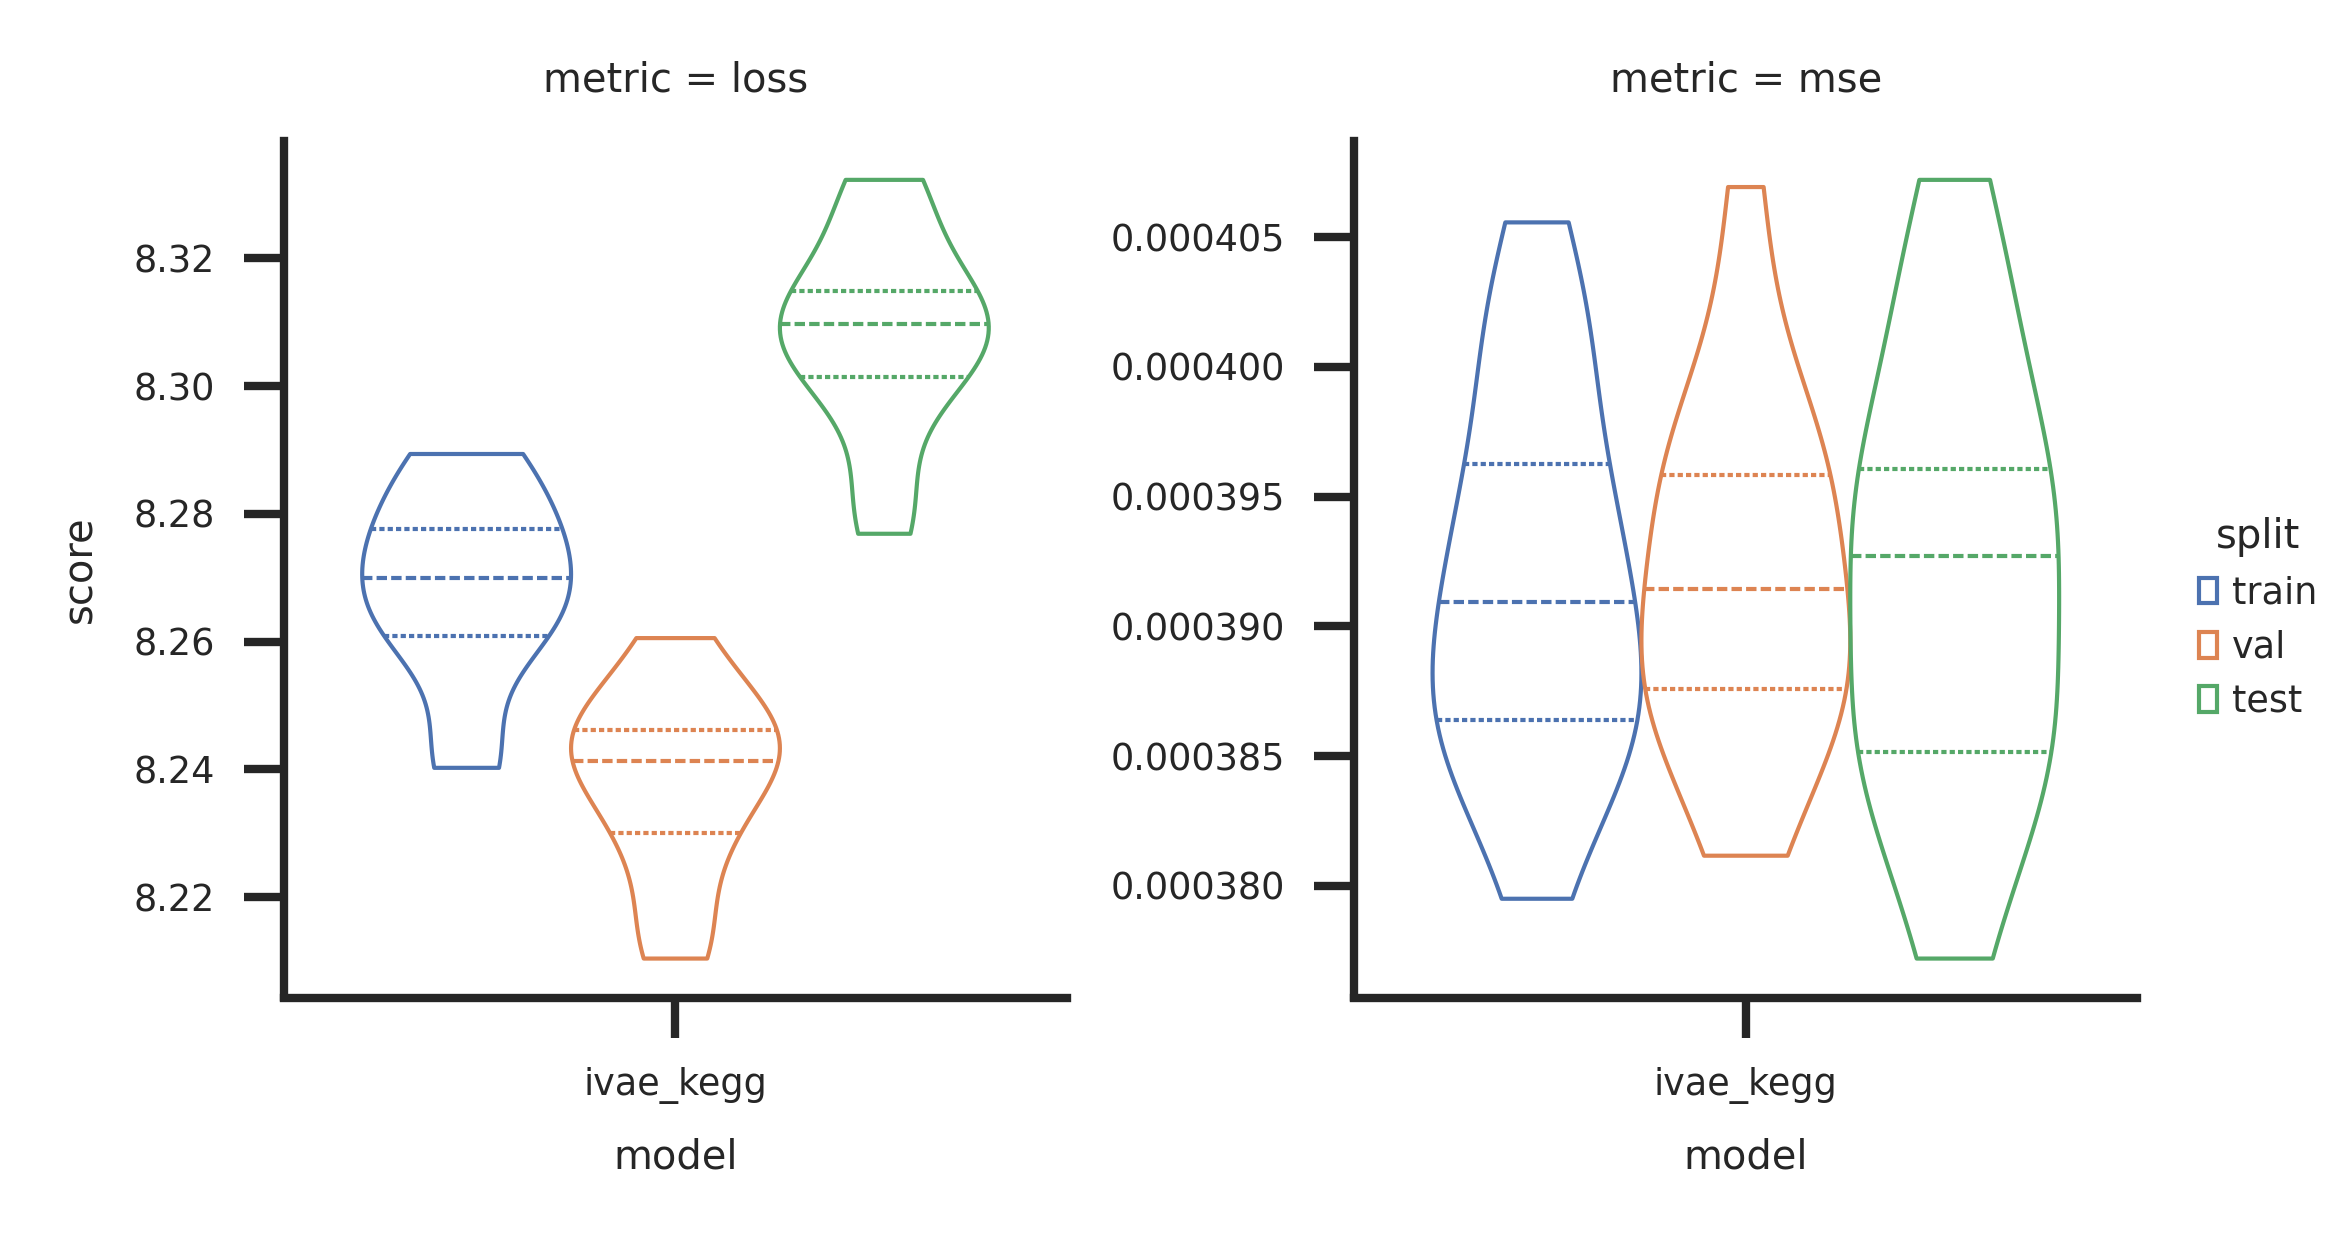

In [40]:
custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(context="paper", font_scale=0.5, style="ticks", rc=custom_params)

g = sns.catplot(
    data=scores_metrics,
    kind="violin",
    col="metric",
    height=2,
    aspect=0.9,
    sharey=False,
    x="model",
    y="score",
    hue="split",
    split=False,
    cut=0,
    fill=False,
    density_norm="count",
    inner="quart",
    linewidth=0.5,
)

In [21]:
scores_informed = {}
non_layer_names = ["split", "layer", "seed", "cell_type", "condition", "model"]

for layer_id in range(1, n_encoding_layers + 1):
    results_layer = [
        pd.read_pickle(
            results_path_model.joinpath(
                f"encodings_layer-{layer_id:02d}_seed-{seed:02d}.pkl"
            )
        )
        for seed in range(N_ITERS)
    ]
    scores_informed[layer_id] = {}
    for split in ["train", "test", "val"]:
        results = [
            x.loc[x["split"] == split].drop(non_layer_names, axis=1)
            for x in results_layer
        ]
        scores_informed[layer_id][split] = []
        for seed_i in range(N_ITERS):
            for seed_j in range(seed_i + 1, N_ITERS):
                scores_informed[layer_id][split].append(
                    weightedtau(
                        get_importances(data=results[seed_i], abs=True),
                        get_importances(data=results[seed_j], abs=True),
                    )[0]
                )

In [22]:
scores_informed = (
    pd.DataFrame.from_dict(scores_informed)
    .melt(var_name="layer", value_name="score", ignore_index=False)
    .reset_index(names=["split"])
    .explode("score")
)
scores_informed["score"] = scores_informed["score"].astype("float")
scores_informed["model"] = f"ivae_{model_kind}"
scores_informed.to_pickle(results_path_model.joinpath("scores_informed.pkl"))

In [23]:
scores_informed.head()

,split,layer,score,model
0,train,1,0.773972,ivae_kegg
0,train,1,0.754863,ivae_kegg
0,train,1,0.762020,ivae_kegg
0,train,1,0.744900,ivae_kegg
0,train,1,0.747843,ivae_kegg


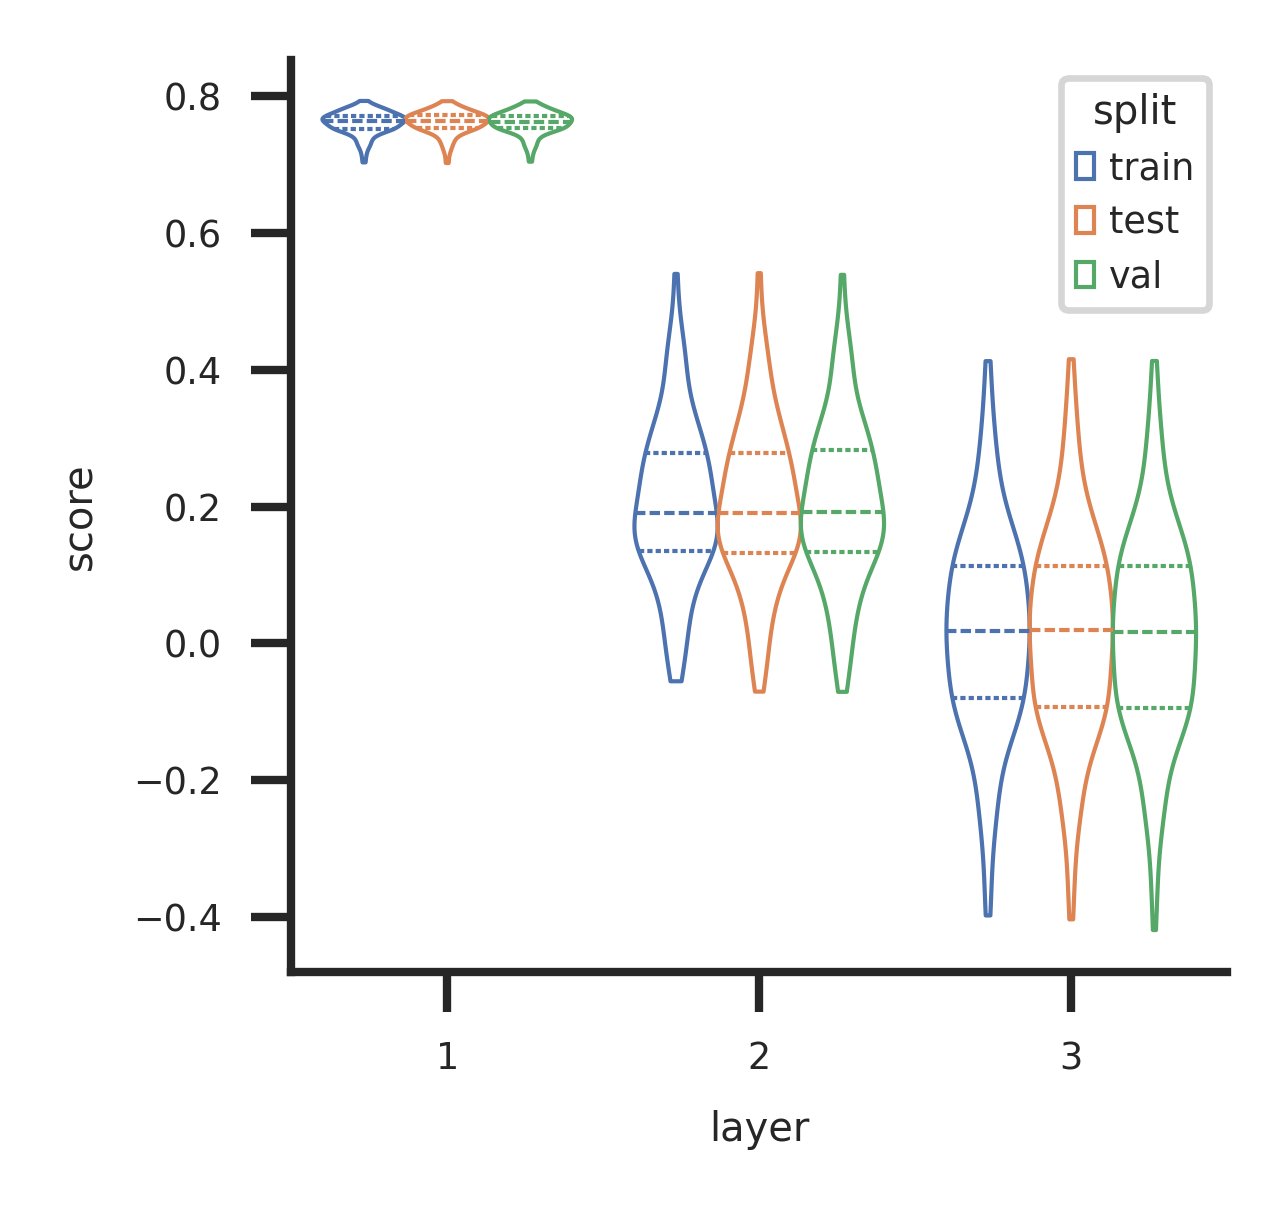

In [45]:
custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(context="paper", font_scale=0.5, style="ticks", rc=custom_params)
plt.figure(figsize=(2, 2))
sns.violinplot(
    data=scores_informed,
    x="layer",
    y="score",
    hue="split",
    split=False,
    cut=0,
    fill=False,
    density_norm="count",
    inner="quart",
    linewidth=0.5,
)
sns.despine()

In [25]:
from sklearn.cluster import MiniBatchKMeans
from multiprocessing import cpu_count
from sklearn.metrics.cluster import adjusted_mutual_info_score

batch_size = 256 * cpu_count() + 1

In [26]:
clust_scores = {}

for layer_id in range(1, n_encoding_layers + 1):
    results_layer = [
        pd.read_pickle(
            results_path_model.joinpath(
                f"encodings_layer-{layer_id:02d}_seed-{seed:02d}.pkl"
            )
        )
        for seed in range(N_ITERS)
    ]

    train_embeddings_lst = [
        x.loc[(x["split"] == "train") & (x["condition"] == "control")]
        for x in results_layer
    ]
    val_embeddings_lst = [
        x.loc[(x["split"] == "val") & (x["condition"] == "control")]
        for x in results_layer
    ]
    test_embeddings_lst = [
        x.loc[(x["split"] == "test") & (x["condition"] == "control")]
        for x in results_layer
    ]

    clust_scores[layer_id] = {}
    clust_scores[layer_id]["train"] = []
    clust_scores[layer_id]["val"] = []
    clust_scores[layer_id]["test"] = []

    for seed in range(N_ITERS):
        y_train = train_embeddings_lst[seed]["cell_type"]
        y_val = val_embeddings_lst[seed]["cell_type"]
        y_test = test_embeddings_lst[seed]["cell_type"]

        train_embeddings = train_embeddings_lst[seed].drop(non_layer_names, axis=1)
        val_embeddings = val_embeddings_lst[seed].drop(non_layer_names, axis=1)
        test_embeddings = test_embeddings_lst[seed].drop(non_layer_names, axis=1)

        model = MiniBatchKMeans(n_clusters=y_train.nunique(), batch_size=batch_size)
        model.fit(train_embeddings)
        clust_scores[layer_id]["train"].append(
            adjusted_mutual_info_score(y_train, model.labels_)
        )
        clust_scores[layer_id]["val"].append(
            adjusted_mutual_info_score(y_val, model.predict(val_embeddings))
        )
        clust_scores[layer_id]["test"].append(
            adjusted_mutual_info_score(y_test, model.predict(test_embeddings))
        )

/home/carlos/github/robustness_informed/.venv/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/carlos/github/robustness_informed/.venv/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/carlos/github/robustness_informed/.venv/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/carlos/github/robustness_informed/.venv/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the va

In [27]:
clust_scores = (
    pd.DataFrame.from_dict(clust_scores)
    .melt(var_name="layer", value_name="score", ignore_index=False)
    .reset_index(names=["split"])
    .explode("score")
)
clust_scores["score"] = clust_scores["score"].astype("float")
scores_informed["model"] = f"ivae_{model_kind}"
clust_scores.to_pickle(results_path_model.joinpath("scores_clustering.pkl"))

In [28]:
clust_scores.head()

,split,layer,score
0,train,1,0.394164
0,train,1,0.346395
0,train,1,0.392959
0,train,1,0.360406
0,train,1,0.374522


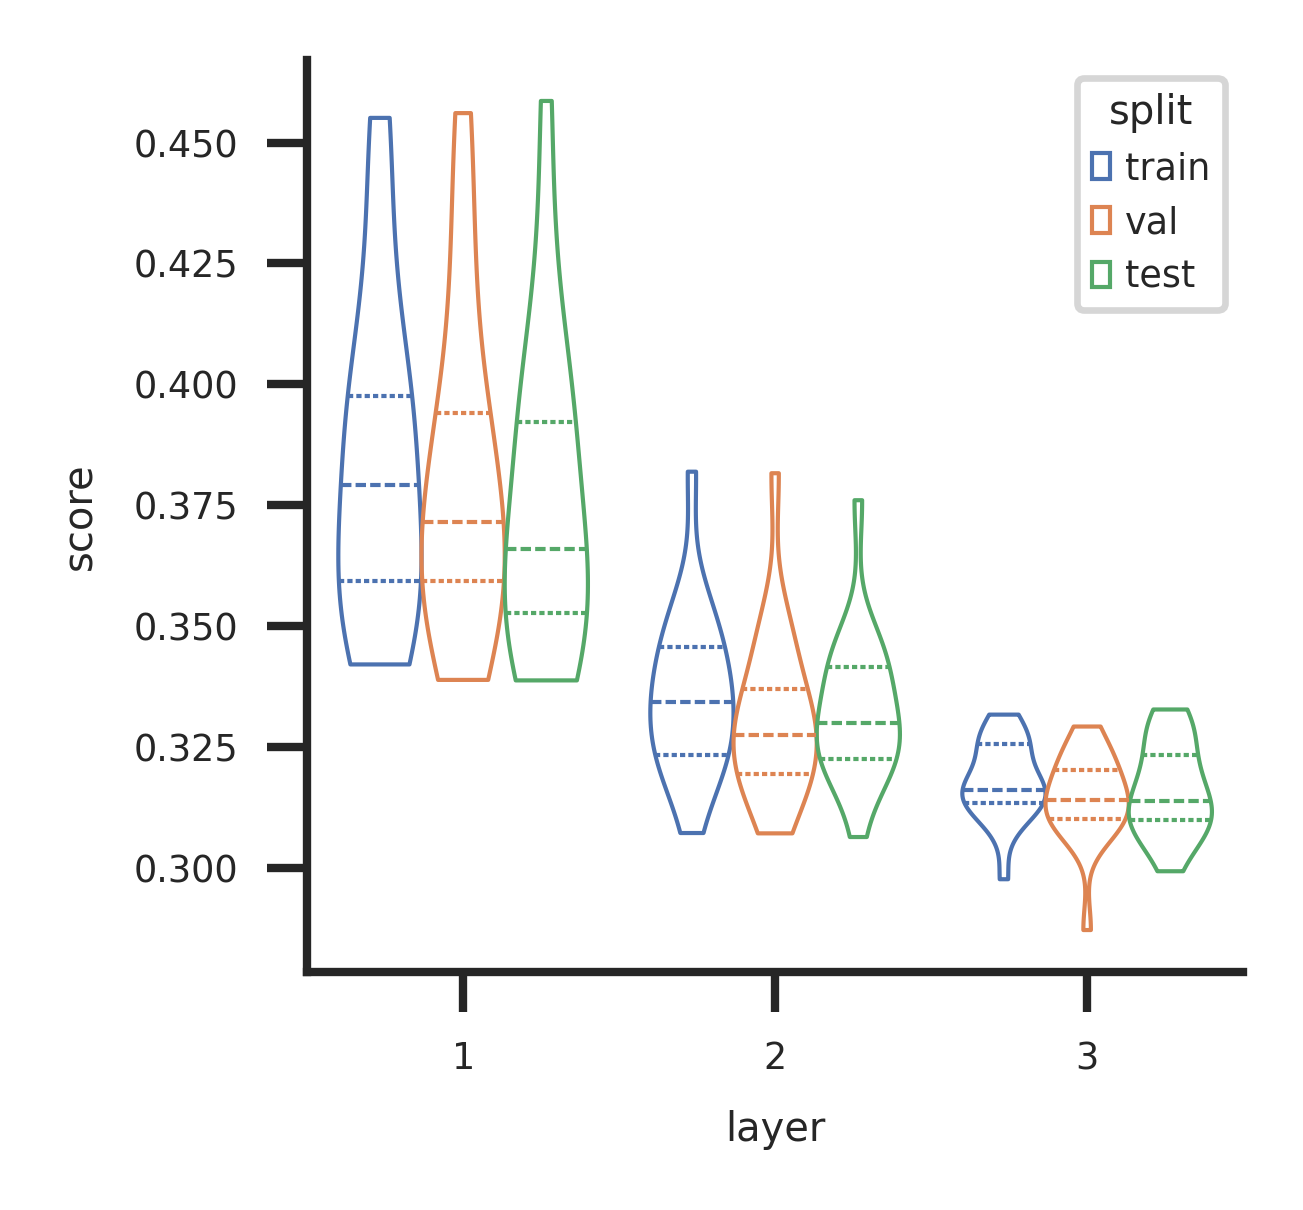

In [29]:
custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(context="paper", font_scale=0.5, style="ticks", rc=custom_params)
plt.figure(figsize=(2, 2))
sns.violinplot(
    data=clust_scores,
    x="layer",
    y="score",
    hue="split",
    split=False,
    cut=0,
    fill=False,
    density_norm="count",
    inner="quart",
    linewidth=0.5,
)
sns.despine()